In [7]:
### Import all what you need:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import numpy as np

import matplotlib.pyplot as plt

import time

# Use the notebook backend (for Jupyter Notebooks)
#%matplotlib notebook

#plt.ion()  # Turn on the interactive mode

In [8]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [9]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!
learning_rate =  1e-3         # learning rate
lambda1, lambda2 = 1e-3, 1e-4 # loss term hyperparameters
epochs = 20001

### Initial, training and test points generation:

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$


In [10]:
#### Generation of t and mu initial points (Initial condition 1) 
point_resolution = 40

ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 1: \n \t [t, mu]: \n{ic1_t_mu}")
#print(f"\n Initial condition 1: \n \t u(t=0, mu) = 1: \n {ic1_scope}")
#print(f"\n Shapes of [t, mu] and u(t=0, mu) = 1: \n\t{ic1_t_mu.shape}, {ic1_scope.shape}")

#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$

In [11]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 2: \n \t [t, mu]: \n{ic2_t_mu}")
#print(f"\n Initial condition 2: \n \t du/dt(t=0, mu) = 0: \n\t {ic2_scope}")
#print(f"\n Shapes of [t, mu] and du/dt(t=0, mu) = 0: \n\t {ic2_t_mu.shape}, {ic2_scope.shape}")

#### Generation of physical domain training points: 

In [12]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

#print(f" Point seed list for mesh grid domain points: \n \t {physic_in_t_mu}")
#print(f"Domain training points: \n \t: {physic_domain_t_mu}")
#print(f"Size of Domain training points: \n \t {physic_domain_t_mu.size()}")

#### Generation of testing points:

In [13]:
#### Generation of t and mu test points within the domain:
point_resolution_test = 100

# Testing points:
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)

# print(f"Point seed list for mesh grid test points: \n \t \n \t: {test_in_t_mu}")
# print(f"Test points \n \t [t, mu]: \n \t {test_domain_t_mu}")
# print(f"Size of the test domain points: \n \t {test_domain_t_mu.size()}")

### Exact solution:

In [14]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [15]:
# Example to check if it works (calculation of the exact solution):
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#u_exact.view(-1,1)
#u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

In [16]:
#physic_in_t_mu[0]

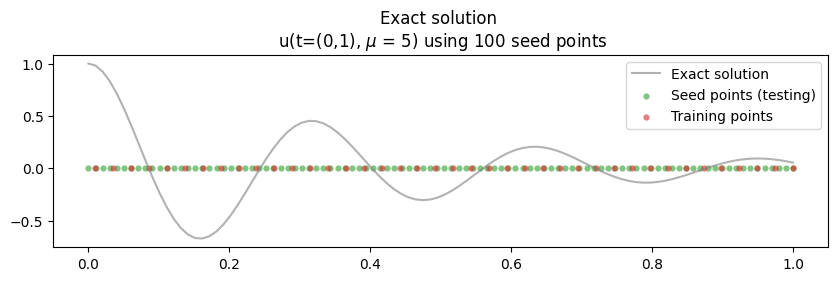

In [17]:
# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_in_t_mu[0], 
        u_exact, 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points (testing)")
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= "Training points")

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {point_resolution_test} seed points")
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [18]:
class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, N_OUTPUT = 1, hidden_layers = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        #self.fcs = nn.Sequential(
        #    nn.Linear(N_INPUT, hidden_layers[0]),
        #    self.activation
        #)
        self.fcs = nn.Linear(N_INPUT, hidden_layers[0])

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_layers[i], hidden_layers[i + 1]),
                self.activation
            ) for i in range(len(hidden_layers) - 1)
        ])

        self.fce = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)


    def forward(self, x):
        x = self.activation(self.fcs(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fce(x)
        return x
    
    def initialize_parameters(self, initialization):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")

    def plot_weights(self):
        weights_biases_dict = self.state_dict()
        #weights_biases_dict = {key: value for key, value in state_dict.items()}
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = 8)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = 8)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = 8)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = 8)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = 8, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network')
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.set_label('Range of Weights and Biases') 
        
        # Show the plots
        plt.show()

## STEP 3: Instantiate the Model Class

In [19]:
original_input_size = 2
original_hidden_layers = [4]
original_output_size = 1
original_model = FCN(original_input_size, original_output_size, original_hidden_layers, activation='Tanh', initialization='Xavier')
#original_model.plot_weights()

### Checking the model using test points and a constant mu value:

In [20]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")

In [21]:
# NO es necesario porque se mantiene constante mu
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()
#print(f"Domain training points: \n \t: {test_domain_t_constant_mu}")

In [22]:
test_predicted = original_model(test_in_t_constant_mu)
#test_predicted.size()
#test_predicted

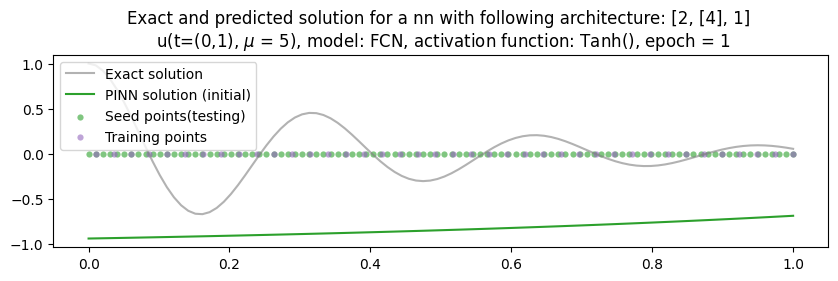

In [23]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
### model and activation has to be manually adapted
plt.title(f"Exact and predicted solution for a nn with following architecture: [{original_input_size}, {original_hidden_layers}, {original_output_size}] \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation}, epoch = 1")
plt.legend()
plt.show()

## STEP 4: Selection of the Optimizer

In [24]:
### model.parameters has to be manually adapted
optimiser = torch.optim.Adam(original_model.parameters(), lr= learning_rate)
optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## STEP 5: Training the PINN

Shape of ic1 residuals: torch.Size([40, 1])

Shape of ic2 residuals: torch.Size([40, 1])
tensor([[0.9456],
        [0.8898],
        [0.8272],
        [0.7605],
        [0.6925],
        [0.6256],
        [0.5615],
        [0.5014],
        [0.4460],
        [0.3955],
        [0.3501],
        [0.3095],
        [0.2734],
        [0.2414],
        [0.2131],
        [0.1882],
        [0.1662],
        [0.1469],
        [0.1298],
        [0.1148],
        [0.1016],
        [0.0900],
        [0.0797],
        [0.0707],
        [0.0627],
        [0.0556],
        [0.0493],
        [0.0438],
        [0.0389],
        [0.0346],
        [0.0308],
        [0.0274],
        [0.0243],
        [0.0217],
        [0.0193],
        [0.0172],
        [0.0153],
        [0.0136],
        [0.0122],
        [0.0108]], grad_fn=<SubBackward0>)
Shape of differential equation residuals: torch.Size([1600, 1])
tensor([[-209.8236],
        [-245.4817],
        [-275.2289],
        ...,
        [-360.5808],
     

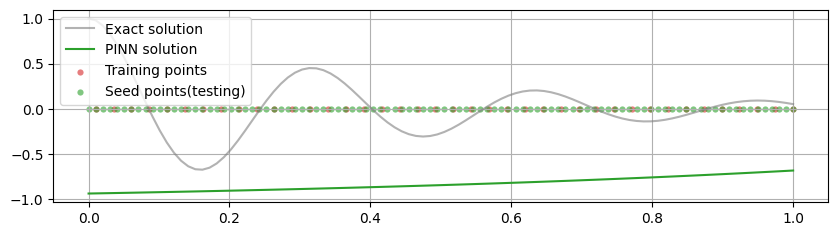

Saved the checkpoint corresponding to epoch: 0
Shape of ic1 residuals: torch.Size([40, 1])

Shape of ic2 residuals: torch.Size([40, 1])
tensor([[-0.3050],
        [-0.3289],
        [-0.3507],
        [-0.3695],
        [-0.3851],
        [-0.3974],
        [-0.4065],
        [-0.4127],
        [-0.4165],
        [-0.4183],
        [-0.4184],
        [-0.4171],
        [-0.4149],
        [-0.4119],
        [-0.4082],
        [-0.4042],
        [-0.3998],
        [-0.3952],
        [-0.3903],
        [-0.3854],
        [-0.3802],
        [-0.3750],
        [-0.3696],
        [-0.3641],
        [-0.3585],
        [-0.3527],
        [-0.3469],
        [-0.3409],
        [-0.3348],
        [-0.3286],
        [-0.3222],
        [-0.3158],
        [-0.3092],
        [-0.3026],
        [-0.2958],
        [-0.2890],
        [-0.2820],
        [-0.2751],
        [-0.2680],
        [-0.2610]], grad_fn=<SubBackward0>)
Shape of differential equation residuals: torch.Size([1600, 1])
tensor([[69.623

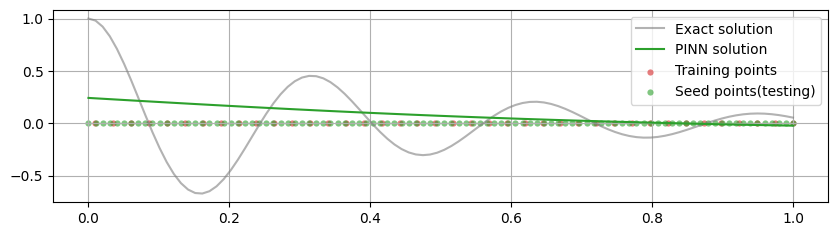

Saved the checkpoint corresponding to epoch: 1000
Training elapsed time (s): 2.102792739868164


In [25]:
epochs = 1001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []



for i in range(epochs):
    optimiser.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= original_model(ic1_t_mu)
    
    residuals_ic1 = ic1_predicted - ic1_scope
    
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    
    residuals_ic2 = ic2_du_dt- ic2_scope
    
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = original_model(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    
    residuals_differential_equation = physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted 
    
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimiser.step()
    
    
    if i%1000 == 0:
        print(f"Shape of ic1 residuals: {residuals_ic1.shape}")
        #print(residuals_ic1)
        print()
        print(f"Shape of ic2 residuals: {residuals_ic2.shape}")
        print(residuals_ic2)
        print(f"Shape of differential equation residuals: {residuals_differential_equation.shape}")
        print(residuals_differential_equation)

        
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted = original_model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        #plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation()}, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": original_model.state_dict(),
                    "optimiser_state_dict": optimiser.state_dict(),
                    "loss": loss,
                   },                    
                    f"lr{learning_rate}_epoch{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")
        

In [26]:
x = physic_domain_t_mu[:,0].detach()
y = physic_domain_t_mu[:,1].detach()
z = residuals_differential_equation.flatten().detach()

In [27]:
x.shape

torch.Size([1600])

In [28]:
z.flatten().shape

torch.Size([1600])

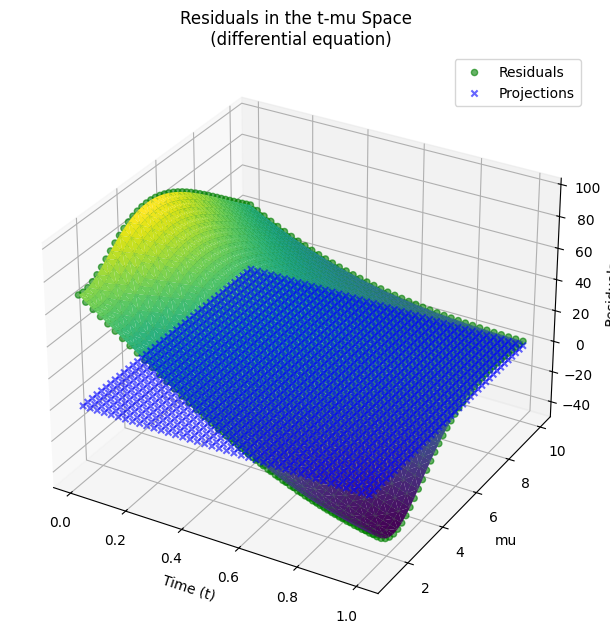

In [29]:
fig = plt.figure(figsize = (10,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.6, c='g', marker='o', label='Residuals')
ax.scatter(x, y, torch.zeros_like(z), alpha=0.6, c='b', marker='x', label='Projections')
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
#ax.plot_surface(physic_domain_t_mu[:,0].detach(), physic_domain_t_mu[:,1].detach(), residuals, alpha=0.2, color='g')
ax.set_xlabel('Time (t)')
ax.set_ylabel('mu')
ax.set_zlabel('Residuals')
plt.title('Residuals in the t-mu Space \n (differential equation)')
ax.legend()
plt.show()

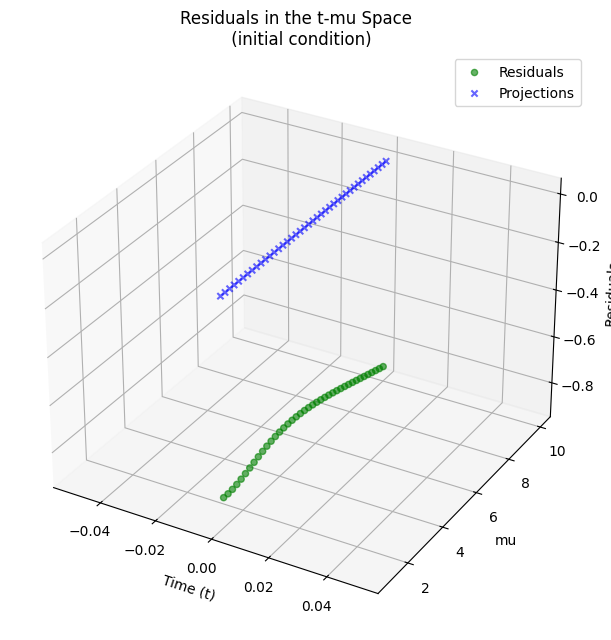

In [30]:
x_ic1_t_mu = ic1_t_mu[:,0].detach()
y_ic1_t_mu = ic1_t_mu[:,1].detach()
z_ic1_t_mu = residuals_ic1.flatten().detach()
fig = plt.figure(figsize = (10,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_ic1_t_mu, y_ic1_t_mu, z_ic1_t_mu, alpha=0.6, c='g', marker='o', label='Residuals')
ax.scatter(x_ic1_t_mu, y_ic1_t_mu, torch.zeros_like(z_ic1_t_mu), alpha=0.6, c='b', marker='x', label='Projections')
#ax.plot_trisurf(x_ic1_t_mu, y_ic1_t_mu, z_ic1_t_mu, cmap='viridis', edgecolor='none')
#ax.plot_surface(physic_domain_t_mu[:,0].detach(), physic_domain_t_mu[:,1].detach(), residuals, alpha=0.2, color='g')
ax.set_xlabel('Time (t)')
ax.set_ylabel('mu')
ax.set_zlabel('Residuals')
plt.title('Residuals in the t-mu Space \n (initial condition)')
ax.legend()
plt.show()    

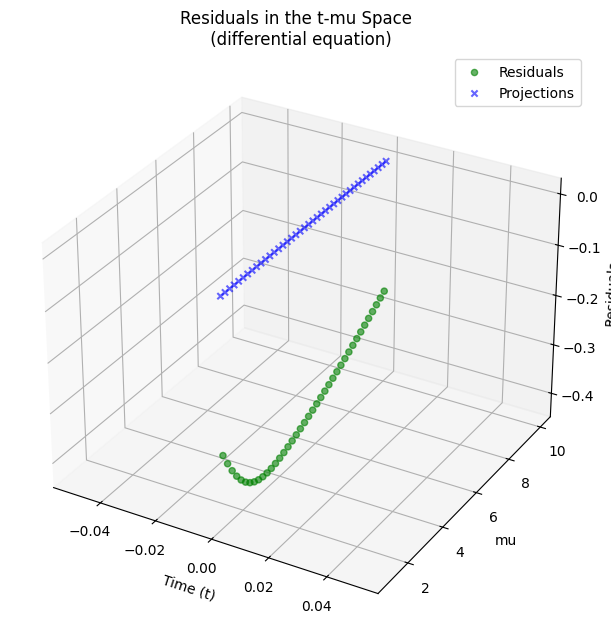

In [31]:
x_ic2_t_mu = ic1_t_mu[:,0].detach()
y_ic2_t_mu = ic1_t_mu[:,1].detach()
z_ic2_t_mu = residuals_ic2.flatten().detach()
fig = plt.figure(figsize = (10,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_ic2_t_mu, y_ic2_t_mu, z_ic2_t_mu, alpha=0.6, c='g', marker='o', label='Residuals')
ax.scatter(x_ic2_t_mu, y_ic2_t_mu, torch.zeros_like(z_ic2_t_mu), alpha=0.6, c='b', marker='x', label='Projections')
#ax.plot_trisurf(x_ic1_t_mu, y_ic1_t_mu, z_ic1_t_mu, cmap='viridis', edgecolor='none')
#ax.plot_surface(physic_domain_t_mu[:,0].detach(), physic_domain_t_mu[:,1].detach(), residuals, alpha=0.2, color='g')
ax.set_xlabel('Time (t)')
ax.set_ylabel('mu')
ax.set_zlabel('Residuals')
plt.title('Residuals in the t-mu Space \n (differential equation)')
ax.legend()
plt.show()

In [32]:
max_values, max_indices = torch.max(z_ic2_t_mu, dim = 0)

In [33]:
print(max_values)

tensor(-0.2610)


In [34]:
print(max_indices)

tensor(39)


## Test Loss to avoid overfitting

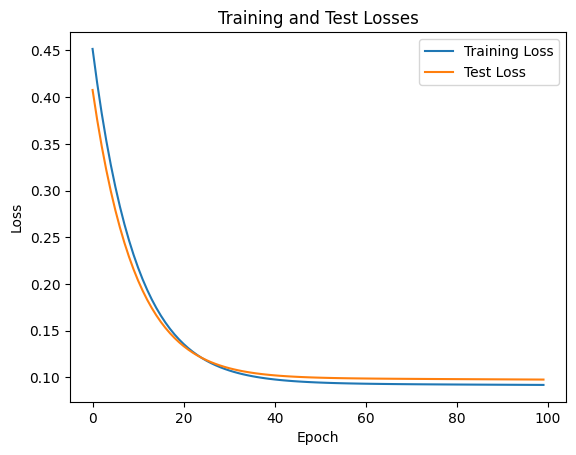

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the fully connected neural network
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate some random data for demonstration
X = torch.rand(1000, 5)  # 1000 samples, 5 features
y = torch.rand(1000, 1)  # Regression task, single output

# Define the train-test split ratio
train_ratio = 0.8
train_size = int(train_ratio * len(X))
test_size = len(X) - train_size

# Split data into training and testing sets
X_train, X_test = torch.split(X, [train_size, test_size])
y_train, y_test = torch.split(y, [train_size, test_size])

# Define hyperparameters
input_size = X.shape[1]
hidden_size = 10
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Initialize the model
model = FullyConnectedNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store losses for plotting
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate on test set to check for overfitting
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


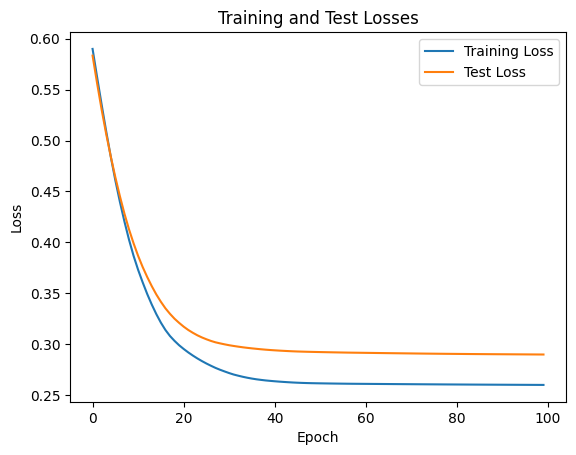

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss function example (absolute error)
        loss = torch.mean(torch.abs(predicted - target))
        return loss

# Define the fully connected neural network
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate some random data for demonstration
X = torch.rand(1000, 5)  # 1000 samples, 5 features
y = torch.rand(1000, 1)  # Regression task, single output

# Define the train-test split ratio
train_ratio = 0.8
train_size = int(train_ratio * len(X))
test_size = len(X) - train_size

# Split data into training and testing sets
X_train, X_test = torch.split(X, [train_size, test_size])
y_train, y_test = torch.split(y, [train_size, test_size])

# Define hyperparameters
input_size = X.shape[1]
hidden_size = 10
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Initialize the model
model = FullyConnectedNN(input_size, hidden_size, output_size)

# Define custom loss function and optimizer
custom_criterion = CustomLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store losses for plotting
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = custom_criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate on test set to check for overfitting
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = custom_criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = torch.sin(self.fc1(x))
        out = torch.sin(self.fc2(out))
        out = self.fc3(out)
        return out

class DampedHarmonicOscillatorPINN:
    def __init__(self, input_size=2, hidden_size=50, output_size=1, num_epochs=10000, lr=0.001):
        self.model = NeuralNet(input_size, hidden_size, output_size)
        self.num_epochs = num_epochs
        self.lr = lr
        self.training_losses = []
        self.test_losses = []

    def loss_fn(self, pde_loss, boundary_loss):
        return pde_loss.mean() + boundary_loss.mean()

    def damped_harmonic_oscillator(self, x, t, u):
        gamma = 0.1  # damping coefficient
        k = 1.0      # spring constant
        m = 1.0      # mass
        return -gamma * u - (k/m) * x

    # def compute_pde_loss(self, x_pde, t_pde):
    #     x_pde.requires_grad = True
    #     t_pde.requires_grad = True

    #     u_pred = self.model(torch.cat((x_pde, t_pde), dim=1))
    #     x_grad = torch.autograd.grad(u_pred.sum(), x_pde, create_graph=True)[0]
    #     t_grad = torch.autograd.grad(u_pred.sum(), t_pde, create_graph=True)[0]

    #     u_t = t_grad[:, 0]
    #     u_xx = torch.autograd.grad(x_grad[:, 0], x_pde, create_graph=True)[0][:, 0]

    #     pde_loss = u_t - self.damped_harmonic_oscillator(x_pde, t_pde, u_pred) - u_xx
        
    #     return pde_loss
    def compute_pde_loss(self, x_pde, t_pde):
        x_pde.requires_grad = True
        t_pde.requires_grad = True
    
        u_pred = self.model(torch.cat((x_pde, t_pde), dim=1))
        x_grad = torch.autograd.grad(u_pred.sum(), x_pde, create_graph=True)[0]
        t_grad = torch.autograd.grad(u_pred.sum(), t_pde, create_graph=True)[0]
    
        u_t = t_grad[:, 0]
        
        # Compute second derivative
        u_xx = torch.zeros_like(x_grad[:, 0])
        for i in range(x_pde.shape[0]):
            u_xx[i] = torch.autograd.grad(x_grad[i].sum(), x_pde[i], create_graph=True)[0][0]
    
        pde_loss = u_t - self.damped_harmonic_oscillator(x_pde, t_pde, u_pred) - u_xx
        
        return pde_loss


    def compute_boundary_loss(self, x_lb, x_ub, t_lb, t_ub):
        u_lb = self.model(torch.cat((x_lb, t_lb), dim=1))
        u_ub = self.model(torch.cat((x_ub, t_ub), dim=1))

        boundary_loss = (u_lb - 0)**2 + (u_ub - 0)**2  # Natural boundary condition
        
        return boundary_loss

    def train(self, x_train, t_train, x_test, t_test):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        for epoch in range(self.num_epochs):
            optimizer.zero_grad()

            pde_loss_train = self.compute_pde_loss(x_train, t_train)
            boundary_loss_train = self.compute_boundary_loss(x_train[0:2], x_train[2:4], t_train[0:2], t_train[2:4])

            loss_train = self.loss_fn(pde_loss_train, boundary_loss_train)
            
            loss_train.backward()
            optimizer.step()

            self.training_losses.append(loss_train.item())

            if epoch % 100 == 0:
                print(f'Training - Epoch [{epoch+1}/{self.num_epochs}], Total Loss: {loss_train.item()}')

            # Compute test loss
            pde_loss_test = self.compute_pde_loss(x_test, t_test)
            boundary_loss_test = self.compute_boundary_loss(x_test[0:2], x_test[2:4], t_test[0:2], t_test[2:4])

            loss_test = self.loss_fn(pde_loss_test, boundary_loss_test)

            self.test_losses.append(loss_test.item())

            if epoch % 100 == 0:
                print(f'Test - Epoch [{epoch+1}/{self.num_epochs}], Total Loss: {loss_test.item()}')

    def plot_loss(self):
        plt.plot(self.training_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.show()

# Training and test data
x_train = torch.tensor(np.random.uniform(-1, 1, (4000, 1)), dtype=torch.float32, requires_grad=True)
t_train = torch.tensor(np.random.uniform(0, 2, (4000, 1)), dtype=torch.float32, requires_grad=True)

x_test = torch.tensor(np.random.uniform(-1, 1, (1000, 1)), dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(np.random.uniform(0, 2, (1000, 1)), dtype=torch.float32, requires_grad=True)

# Create and train the PINN
pinn = DampedHarmonicOscillatorPINN()
pinn.train(x_train, t_train, x_test, t_test)

# Plot the loss
pinn.plot_loss()


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

## Random

In [ ]:
import torch

low = 5  # Inclusive
high = 10  # Exclusive
size = (1,)  # Size of the output tensor. Use (n,) for n random integers.

random_integers = torch.randint(low, high, size)
print(random_integers)

In [ ]:
import random

# Define the range
a = 5  # Inclusive
b = 10 # Inclusive

# Generate a random integer within the range [a, b]
random_integer = random.randint(a, b)

print(random_integer)


In [ ]:
import torch

def random_tensor_in_range(num_elements, low, high):
    rand_tensor = (torch.rand(num_elements) * (high - low)) + low
    return rand_tensor

# Example usage
num_elements = 10
low = 0.0
high = 100.0

random_tensor = random_tensor_in_range(num_elements, low, high)
print(random_tensor)


In [ ]:
import torch

def random_linspace_sorted(low, high, steps):
    rand_numbers = torch.rand(steps)
    linspace_tensor = rand_numbers * (high - low) + low
    sorted_tensor = torch.sort(linspace_tensor).values
    return sorted_tensor

# Example usage
low = 0
high = 100
steps = 10

random_linspace_sorted_tensor = random_linspace_sorted(low, high, steps)
print(random_linspace_sorted_tensor)


In [ ]:
import torch
import matplotlib.pyplot as plt

# Generate and sort random numbers (previous example's logic)
a = 1
b = 100
n = 40
mean = (a + b) / 2
std = (b - a) / 6

random_points = torch.randn(n) * std + mean
random_points = torch.clamp(random_points, min=a, max=b)
random_points[-1] = b
sorted_random_points, _ = torch.sort(random_points)

# Plotting
plt.bar(range(n), sorted_random_points.numpy(), color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sorted Random Numbers')
plt.xticks(range(n))
plt.ylim(a, b)

# Display the plot
plt.show()


In [ ]:
import torch

a = 1  # start of the range
b = 10 # end of the range
n = 5  # number of random points

# Generate n random floating-point numbers in the range [a, b]
random_floats = torch.rand(n) * (b - a) + a
print(random_floats)


In [ ]:
import torch

a = 1.0  # start of the range, conceptually excluded
b = 10.0 # end of the range, conceptually excluded
n = 5  # number of random points

# Generate n random floating-point numbers in the range (a, b)
random_floats = torch.sort(torch.rand(n) * (b - a) + a)

print(random_floats)


In [ ]:
import torch

# Generate a tensor of random floating-point numbers within a specified range
a = 1.0  # Start of the range, conceptually excluded
b = 10.0 # End of the range, conceptually excluded
n = 5    # Number of random points

random_floats = torch.rand(n) * (b - a) + a

# Sort the tensor of floating-point numbers
sorted_floats, sorted_indices = torch.sort(random_floats)

print("original values:", random_floats)
print("Sorted values:", sorted_floats)
print("Indices of sorted values:", sorted_indices)


In [ ]:
import torch
import matplotlib.pyplot as plt

# Generate a tensor of random floating-point numbers within a specified range
a = 1.0  # Start of the range, conceptually excluded
b = 10.0 # End of the range, conceptually excluded
n = 5    # Number of random points

random_floats = torch.rand(n) * (b - a) + a

# Sort the tensor of floating-point numbers
sorted_floats, sorted_indices = torch.sort(random_floats)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Create two subplots

# Original positions
axes[0].bar(range(n), random_floats.numpy(), color='skyblue', alpha=0.7)
axes[0].set_title('Original Positions')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')
axes[0].set_xticks(range(n))
axes[0].set_ylim([a, b])

# Sorted positions
axes[1].bar(range(n), sorted_floats.numpy(), color='salmon', alpha=0.7)
axes[1].set_title('Sorted Positions')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].set_xticks(range(n))
axes[1].set_ylim([a, b])

plt.tight_layout()
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

# Generate a tensor of random floating-point numbers within a specified range
a = 1.0  # Start of the range, conceptually excluded
b = 10.0 # End of the range, conceptually excluded
n = 5    # Number of random points

random_floats = torch.rand(n) * (b - a) + a

# Sort the tensor of floating-point numbers
sorted_floats, _ = torch.sort(random_floats)

# Plotting
plt.figure(figsize=(8, 2))
# Plot a line for the range [a, b]
plt.plot([a, b], [0, 0], 'k-', lw=2)  # 'k-' creates a black line, lw specifies line width

# Add markers for the sorted random values
for value in sorted_floats:
    plt.plot(value.item(), 0, 'rx', markersize=10)  # 'rx' creates red 'x' markers

plt.title('Sorted Random Values within the Range (a, b)')
plt.yticks([])  # Hide y-axis ticks
plt.xticks(sorted_floats.numpy())  # Show ticks only for the sorted values
plt.xlim(a - 0.1 * (b - a), b + 0.1 * (b - a))  # Extend x-axis limits slightly for visual clarity

plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

# Generate a tensor of random floating-point numbers within a specified range
a = 1.0  # Start of the range, conceptually excluded
b = 10.0 # End of the range, conceptually excluded
n = 20    # Number of random points

random_floats = torch.rand(n) * (b - a) + a

# Sort the tensor of floating-point numbers
sorted_floats, _ = torch.sort(random_floats)

# Plotting
plt.figure(figsize=(20, 2))
# Plot a line for the range [a, b]
plt.plot([a, b], [0, 0], 'k-', lw=2)  # 'k-' creates a black line, lw specifies line width

# Add markers for the sorted random values in a vectorized way
plt.plot(sorted_floats, [0] * n, 'rx', markersize=10)  # 'rx' creates red 'x' markers

plt.title('Sorted Random Values within the Range (a, b)')
plt.yticks([])  # Hide y-axis ticks
plt.xticks(sorted_floats.numpy())  # Show ticks only for the sorted values
plt.xlim(a - 0.1 * (b - a), b + 0.1 * (b - a))  # Extend x-axis limits slightly for visual clarity

plt.show()


In [ ]:
torch.rand(10,1)

In [ ]:
# Example usage
num_elements = 1
low = 0
high = 100
rand_tensor = torch.randint(low, high, (num_elements,))
print(rand_tensor)

In [ ]:
import random

# Define the range
a = 30  # Inclusive
b = 100 # Inclusive
point_resolution = random.randint(a, b)
print(point_resolution)

### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

print(f" Point seed list for mesh grid domain points: \n \t {physic_in_t_mu}  \n Shape: {physic_in_t_mu[0].shape}")
print(f"Domain training points: \n \t: {physic_domain_t_mu}")
#print(f"Size of Domain training points: \n \t {physic_domain_t_mu.size()}")

## Test loss

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = torch.sin(self.fc1(x))
        out = torch.sin(self.fc2(out))
        out = self.fc3(out)
        return out

class DampedHarmonicOscillatorPINN:
    def __init__(self, input_size=2, hidden_size=50, output_size=1, num_epochs=10000, lr=0.001):
        self.model = NeuralNet(input_size, hidden_size, output_size)
        self.num_epochs = num_epochs
        self.lr = lr
        self.training_losses = []
        self.test_losses = []

    def loss_fn(self, pde_loss, boundary_loss):
        return pde_loss.mean() + boundary_loss.mean()

    def damped_harmonic_oscillator(self, x, t, u):
        gamma = 0.1  # damping coefficient
        k = 1.0      # spring constant
        m = 1.0      # mass
        return -gamma * u - (k/m) * x

    def compute_pde_loss(self, x_pde, t_pde):
        x_pde.requires_grad = True
        t_pde.requires_grad = True

        u_pred = self.model(torch.cat((x_pde, t_pde), dim=1))
        x_grad = torch.autograd.grad(u_pred.sum(), x_pde, create_graph=True)[0]
        t_grad = torch.autograd.grad(u_pred.sum(), t_pde, create_graph=True)[0]

        u_t = t_grad[:, 0]
    
        # Compute second derivative
        u_xx = torch.zeros_like(x_grad[:, 0])
        for i in range(x_pde.shape[0]):
            u_xx[i] = torch.autograd.grad(x_grad[i].sum(), x_pde[i], create_graph=True)[0][0]

        pde_loss = u_t - self.damped_harmonic_oscillator(x_pde, t_pde, u_pred) - u_xx
        
        return pde_loss

    def compute_boundary_loss(self, x_lb, x_ub, t_lb, t_ub):
        u_lb = self.model(torch.cat((x_lb, t_lb), dim=1))
        u_ub = self.model(torch.cat((x_ub, t_ub), dim=1))

        boundary_loss = (u_lb - 0)**2 + (u_ub - 0)**2  # Natural boundary condition
        
        return boundary_loss

    def train(self, x_train, t_train, x_test, t_test):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        for epoch in range(self.num_epochs):
            optimizer.zero_grad()

            pde_loss_train = self.compute_pde_loss(x_train, t_train)
            boundary_loss_train = self.compute_boundary_loss(x_train[0:2], x_train[2:4], t_train[0:2], t_train[2:4])

            loss_train = self.loss_fn(pde_loss_train, boundary_loss_train)
            
            loss_train.backward()
            optimizer.step()

            self.training_losses.append(loss_train.item())

            if epoch % 100 == 0:
                print(f'Training - Epoch [{epoch+1}/{self.num_epochs}], Total Loss: {loss_train.item()}')

            # Compute test loss
            pde_loss_test = self.compute_pde_loss(x_test, t_test)
            boundary_loss_test = self.compute_boundary_loss(x_test[0:2], x_test[2:4], t_test[0:2], t_test[2:4])

            loss_test = self.loss_fn(pde_loss_test, boundary_loss_test)

            self.test_losses.append(loss_test.item())

            if epoch % 100 == 0:
                print(f'Test - Epoch [{epoch+1}/{self.num_epochs}], Total Loss: {loss_test.item()}')

    def plot_loss(self):
        plt.plot(self.training_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.show()

    def plot_residuals(self, x_train, t_train):
        self.model.eval()
        with torch.no_grad():
            u_pred = self.model(torch.cat((x_train, t_train), dim=1))

        x_train = x_train.detach().numpy()
        t_train = t_train.detach().numpy()
        u_exact = np.sin(x_train) * np.exp(-0.1 * t_train)  # Exact solution

        residuals = u_exact - u_pred.numpy()

        plt.scatter(x_train, t_train, c=residuals, cmap='coolwarm')
        plt.colorbar(label='Residuals')
        plt.xlabel('x_train')
        plt.ylabel('t_train')
        plt.title('Residuals of Training Points')
        plt.show()

# Training and test data
x_train = torch.linspace(-1, 1, 100).view(-1, 1)
t_train = torch.linspace(0, 2, 100).view(-1, 1)

x_test = torch.linspace(-1, 1, 50).view(-1, 1)
t_test = torch.linspace(0, 2, 50).view(-1, 1)

# Create and train the PINN
pinn = DampedHarmonicOscillatorPINN()
pinn.train(x_train, t_train, x_test, t_test)

# Plot the loss
pinn.plot_loss()

# Plot the residuals for training points
pinn.plot_residuals(x_train, t_train)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

point_resolution = 10

# Generate domain physic loss sample points
physic_in_t_mu = [
    torch.linspace(1e-2, 1, point_resolution).requires_grad_(True),
    torch.linspace(1, 10, point_resolution).requires_grad_(True)
]

physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

# Calculate z values
z = physic_domain_t_mu[:, 0] * physic_domain_t_mu[:, 1]

# Convert z to a NumPy array
z_numpy = z.detach().numpy().reshape(point_resolution, point_resolution)

# Extract x, y values for plotting
x = physic_domain_t_mu[:, 0].detach().numpy().reshape(point_resolution, point_resolution)
y = physic_domain_t_mu[:, 1].detach().numpy().reshape(point_resolution, point_resolution)

# Plotting
plt.figure()

# Contour plot
contour = plt.contourf(x, y, z_numpy, cmap='hot')  # Using 'hot' colormap for heatmap
plt.colorbar(contour)  # Add color bar for reference
# Plot sample points
plt.scatter(physic_domain_t_mu[:, 0].detach(), physic_domain_t_mu[:, 1].detach(), color='white', label='Sample Points', marker='+')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot with Heat Colormap and Sample Points')
plt.legend()
plt.show()



In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
z_numpy.shape

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming data_tensor is your PyTorch tensor with shape (N, 3)
# where each row is an (x, y, z) triplet
data_tensor = torch.tensor([
    [1.0, 2.0, 3.0],
    [2.0, 3.0, 2.5],
    [5.0, 4.0, 5]
    # Add more points as needed
])

# Extract x, y, and z values
x = data_tensor[:, 0].numpy()
y = data_tensor[:, 1].numpy()
z = data_tensor[:, 2].numpy()

# Using tricontour for irregularly spaced data
plt.figure(figsize=(8, 6))
plt.tricontour(x, y, z, levels=15, linewidths=0.5, colors='k')
plt.tricontourf(x, y, z, levels=15, cmap='viridis')  # Filled contour for visualization
plt.colorbar()
plt.title('Contour Plot for Irregularly Spaced Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


## Plotting different number of scatter plots

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_tensors(*tensor_label_pairs, markers=None, colors=None):
    """
    Plot tensors as scatter plot.

    Parameters:
        *tensor_label_pairs: Variable number of tuples where each tuple contains a tensor and its label.
        markers (list): List of marker styles for each tensor. Default is None.
        colors (list): List of marker colors for each tensor. Default is None.
    """
    plt.figure()
    
    # Default markers and colors if not provided
    default_markers = ['o', 's', '^', 'D', 'x', '+', '*']
    default_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    
    for i, (tensor, label) in enumerate(tensor_label_pairs):
        # Determine marker and color for the current tensor
        marker = default_markers[i] if markers is None else markers[i % len(markers)]
        color = default_colors[i] if colors is None else colors[i % len(colors)]
        
        plt.scatter(tensor[:, 0], tensor[:, 1], marker=marker, color=color, label=label)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
tensor1 = torch.randn(10, 2)  # Example tensor 1
tensor2 = torch.randn(15, 2)  # Example tensor 2
tensor3 = torch.randn(20, 2)  # Example tensor 3

# Providing labels, markers, and colors for each tensor
plot_tensors((tensor1, 'Tensor 1'), (tensor2, 'Tensor 2'), (tensor3, 'Tensor 3'), markers=['o', 's', '^'], colors=['blue', 'green', 'red'])


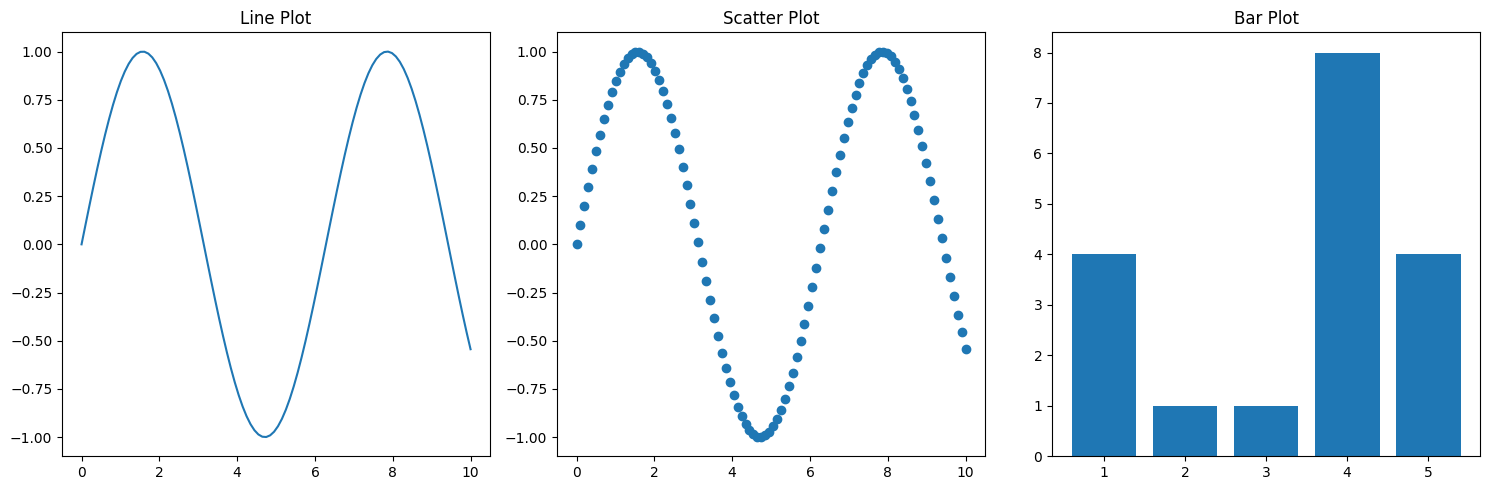

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Line plot
axs[0].plot(x, y)
axs[0].set_title('Line Plot')

# Scatter plot
axs[1].scatter(x, y)
axs[1].set_title('Scatter Plot')

# Bar plot
x_bar = np.arange(1, 6)
y_bar = np.random.randint(1, 10, size=5)
axs[2].bar(x_bar, y_bar)
axs[2].set_title('Bar Plot')

# Display the plots
plt.tight_layout()  # Adjust the layout to make room for the titles and labels
plt.show()
